# Gradient boosting demo - heat island effect

## Intro

### Machine learing

### Gardient boosting

### Heat island effect

### Our question
> Can we see a difference in temperature in a city vs outside of a city?


Kumpula, Helsinki
![kumpula](kumpula_img.png)

Nuuksio, Espoo
![nuuksio](nuuksio_img.png)

### How to answer the question
- compare temperature data from inside a city (Kumpula) and outside a city (Nuuksio). Data is downloaded from the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/download-observations).
- compare predictions of the temperature in this time period using different methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from prophet import Prophet
#from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data cleaning & processing
- load the data
- parse the columns
- add missing rows and impute values
- visualise the data

In [2]:
def read_parse(data, v=False):
    
    df = df = pd.read_csv(data)
    v and display(df)
    # timestamp, datetime object of the form yyyy-mm-dd hh:mm:ss (as DataFrame index column), and y, the average hourly temperature
    # Convert 'Time [Local time]' to a time format
    df['Time [Local time]'] = pd.to_datetime(df['Time [Local time]'], format='%H:%M').dt.time
    # Combine date and time columns into a single timestamp column
    df['timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) + pd.to_timedelta(df['Time [Local time]'].astype(str))
    # Set the timestamp column as the index
    observations_df = df.set_index('timestamp', inplace=False)
    # Drop unnecessary columns
    observations_df.drop(columns=['Observation station', 'Year', 'Month', 'Day', 'Time [Local time]'], inplace=True)
    # Rename the column to 'y'
    observations_df.rename(columns={'Average temperature [°C]': 'y'}, inplace=True)
    v and display(observations_df)

    # add missing rows
    # Create a datetime range with hourly frequency
    hourly_index = pd.date_range(start='2021-04-10', end='2024-05-15', freq='H')

    # Extract the time component and set it as the index
    hourly_index = pd.to_datetime(hourly_index.strftime('%Y-%m-%d %H:%M:%S'))
    #print(hourly_index)

    # Create an empty DataFrame with the hourly index
    empty_df = pd.DataFrame(index=hourly_index)

    # Print the empty DataFrame
    timestamps_df = empty_df.iloc[:-1]
    # display(timestamps_df)
    
    # merge the new index with the data
    merged_df = timestamps_df.merge(observations_df, how='left', left_index=True, right_index=True)
    v and display(merged_df)
    
    return merged_df


In [3]:
v = True
df_noncity = read_parse('Espoo Nuuksio_ 10.4.2021 - 15.5.2024_70cbf32d-bc04-4934-8908-bb0142e91059.csv', v)
df_city = read_parse('Helsinki Kumpula_ 10.4.2021 - 15.5.2024_4929bda1-79f2-43ac-ba67-15cec2d0929f.csv', v)

,Observation station,Year,Month,Day,Time [Local time],Average temperature [°C]
0,Espoo Nuuksio,2021,4,10,00:00,2.6
1,Espoo Nuuksio,2021,4,10,01:00,2.7
2,Espoo Nuuksio,2021,4,10,02:00,2.8
3,Espoo Nuuksio,2021,4,10,03:00,2.7
4,Espoo Nuuksio,2021,4,10,04:00,2.5
...,...,...,...,...,...,...
27118,Espoo Nuuksio,2024,5,14,21:00,13.0
27119,Espoo Nuuksio,2024,5,14,22:00,10.9
27120,Espoo Nuuksio,2024,5,14,23:00,9.5
27121,Espoo Nuuksio,2024,5,15,00:00,8.4


,y
timestamp,
2021-04-10 00:00:00,2.6
2021-04-10 01:00:00,2.7
2021-04-10 02:00:00,2.8
2021-04-10 03:00:00,2.7
2021-04-10 04:00:00,2.5
...,...
2024-05-14 21:00:00,13.0
2024-05-14 22:00:00,10.9
2024-05-14 23:00:00,9.5


,y
2021-04-10 00:00:00,2.6
2021-04-10 01:00:00,2.7
2021-04-10 02:00:00,2.8
2021-04-10 03:00:00,2.7
2021-04-10 04:00:00,2.5
...,...
2024-05-14 19:00:00,17.0
2024-05-14 20:00:00,15.3
2024-05-14 21:00:00,13.0
2024-05-14 22:00:00,10.9


,Observation station,Year,Month,Day,Time [Local time],Average temperature [°C]
0,Helsinki Kumpula,2021,4,10,00:00,3.4
1,Helsinki Kumpula,2021,4,10,01:00,3.7
2,Helsinki Kumpula,2021,4,10,02:00,3.9
3,Helsinki Kumpula,2021,4,10,03:00,3.7
4,Helsinki Kumpula,2021,4,10,04:00,3.5
...,...,...,...,...,...,...
27100,Helsinki Kumpula,2024,5,15,19:00,20.4
27101,Helsinki Kumpula,2024,5,15,20:00,19.5
27102,Helsinki Kumpula,2024,5,15,21:00,18.3
27103,Helsinki Kumpula,2024,5,15,22:00,16.9


,y
timestamp,
2021-04-10 00:00:00,3.4
2021-04-10 01:00:00,3.7
2021-04-10 02:00:00,3.9
2021-04-10 03:00:00,3.7
2021-04-10 04:00:00,3.5
...,...
2024-05-15 19:00:00,20.4
2024-05-15 20:00:00,19.5
2024-05-15 21:00:00,18.3


,y
2021-04-10 00:00:00,3.4
2021-04-10 01:00:00,3.7
2021-04-10 02:00:00,3.9
2021-04-10 03:00:00,3.7
2021-04-10 04:00:00,3.5
...,...
2024-05-14 19:00:00,14.3
2024-05-14 20:00:00,13.4
2024-05-14 21:00:00,12.2
2024-05-14 22:00:00,10.7


### Imputing missing values
Now every hour in the time series has a measurement associated with it. The next step is to impute the missing values with some value. We can have a look what kind of missing values there are in order to make this decision.

In [4]:
def check_missing(merged_df):
    # Count NaN values
    nan_count = merged_df.isna().sum()
    print("NaN count before imputation:", nan_count)

    na_mask = merged_df.isna()

    # Extract the index where NaN values are present
    na_index = merged_df.index[na_mask.any(axis=1)]

    # Print the index of NaN values
    print("Index of NaN values:")
    print([val for val in na_index])

In [5]:
check_missing(df_city)
check_missing(df_noncity)

NaN count before imputation: y    66
dtype: int64
Index of NaN values:
[Timestamp('2021-04-26 10:00:00'), Timestamp('2021-06-29 11:00:00'), Timestamp('2021-06-29 12:00:00'), Timestamp('2021-06-29 13:00:00'), Timestamp('2021-06-29 14:00:00'), Timestamp('2021-06-30 11:00:00'), Timestamp('2021-12-21 14:00:00'), Timestamp('2021-12-21 15:00:00'), Timestamp('2021-12-21 16:00:00'), Timestamp('2022-03-27 03:00:00'), Timestamp('2022-12-13 18:00:00'), Timestamp('2022-12-13 19:00:00'), Timestamp('2022-12-25 05:00:00'), Timestamp('2022-12-25 06:00:00'), Timestamp('2022-12-25 07:00:00'), Timestamp('2022-12-25 08:00:00'), Timestamp('2022-12-25 09:00:00'), Timestamp('2022-12-25 10:00:00'), Timestamp('2022-12-25 11:00:00'), Timestamp('2022-12-25 12:00:00'), Timestamp('2022-12-25 13:00:00'), Timestamp('2022-12-25 14:00:00'), Timestamp('2022-12-25 15:00:00'), Timestamp('2022-12-25 16:00:00'), Timestamp('2022-12-25 17:00:00'), Timestamp('2022-12-25 18:00:00'), Timestamp('2022-12-25 19:00:00'), Timestamp(

It seems like we are missing data from Christmas 2022 in Kumpula. We can use a simple imputation strategy like forward fill to fill in the missing values, however this strategy will not exactly be able to reconstruct the temporal dynamic aspects of the data. A couple days without temporal pattern in 3 years might not affect our results that dramatically.

In [6]:
def impute(merged_df):
    # Impute missing values with the mean using SimpleImputer
    #imputer = SimpleImputer(strategy='mean')
    #imputed_df = pd.DataFrame(imputer.fit_transform(merged_df), columns=merged_df.columns, index=merged_df.index)

    df_ffill = merged_df.fillna(method='ffill')

    # Print the count of NaN values after imputation
    print("NaN count after imputation:")
    print(df_ffill.isna().sum())
    
    return df_ffill

In [7]:
df_city_imp = impute(df_city)
df_noncity_imp = impute(df_noncity)

NaN count after imputation:
y    0
dtype: int64
NaN count after imputation:
y    0
dtype: int64


### Visualisation
It's important to see what the data looks like with your own eyes as a part of pre-processing. Humans have excellent pattern recognition capabilities.

Notice the different temporal patterns, e.g.:
- yearly patterns
- monthly patterns ?
- daily patterns

#### Total time series visualisation

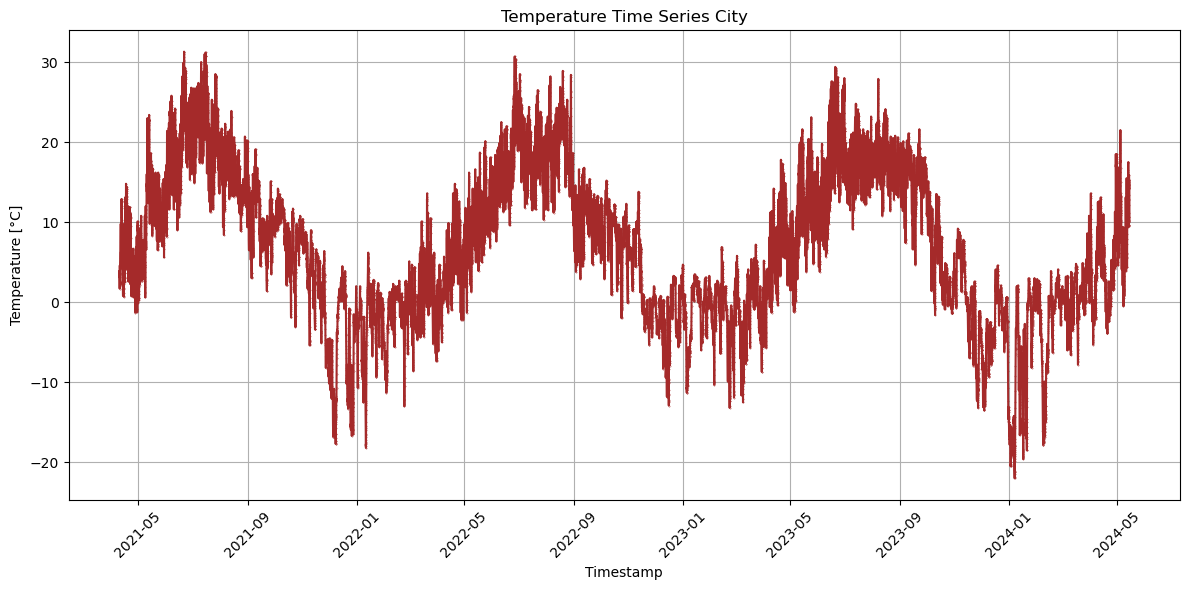

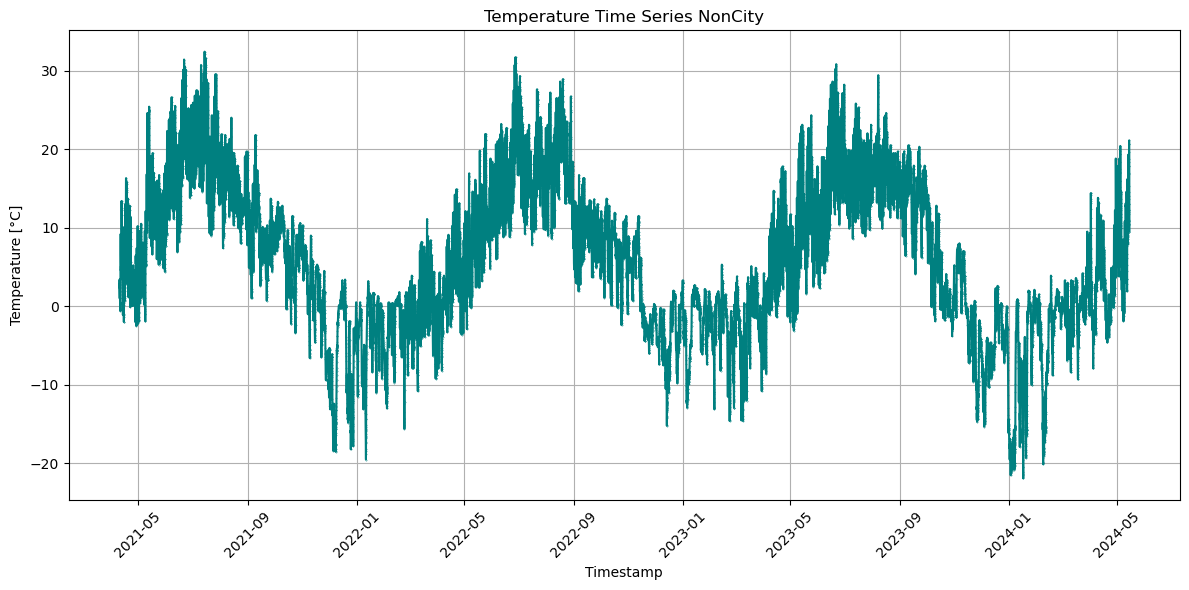

In [8]:
# Plot the temperature time series
df = df_city_imp
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], marker='.',  markersize=0.5, color='brown')
plt.title('Temperature Time Series City')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the temperature time series
df = df_noncity_imp
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], marker='.',  markersize=0.5, color='teal')
plt.title('Temperature Time Series NonCity')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### One month visualisation

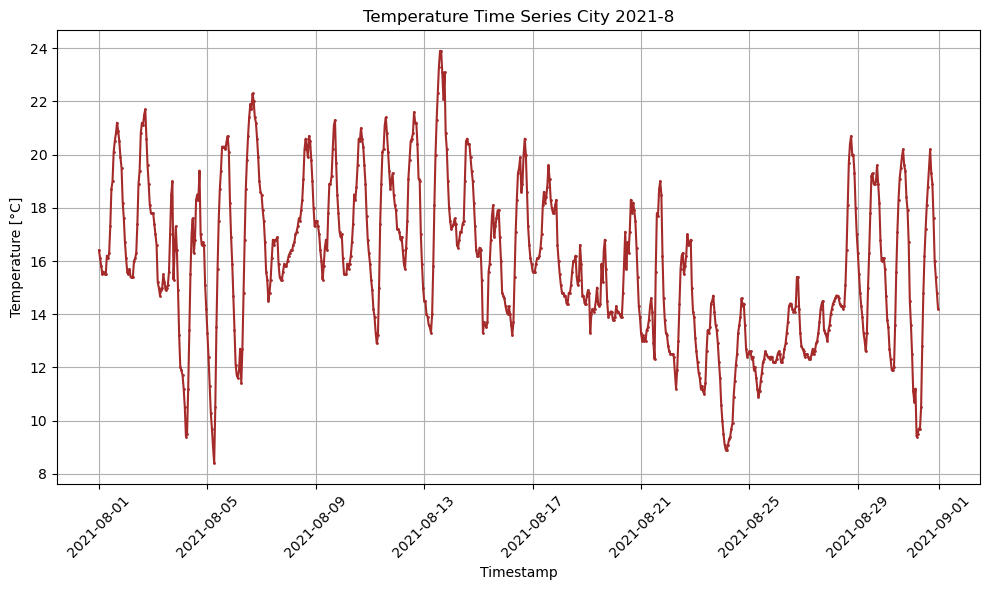

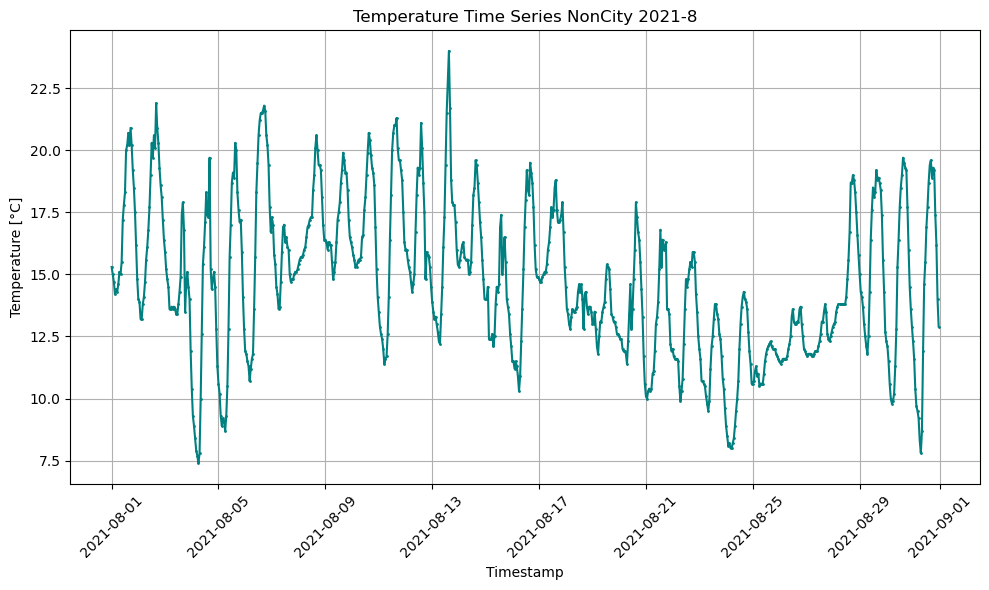

In [9]:
df = df_city_imp
# Filter data for a specific month
year = 2021
month = 8
df_specific_month = df[(df.index.year == year) & (df.index.month == month)]

# Plot the temperature time series for the specific month
plt.figure(figsize=(10, 6))
plt.plot(df_specific_month['y'], marker='.', markersize=2, color='brown')
plt.title(f'Temperature Time Series City {year}-{month}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df = df_noncity_imp
# Filter data for a specific month
month = 8
df_specific_month = df[(df.index.year == year) & (df.index.month == month)]

# Plot the temperature time series for the specific month
plt.figure(figsize=(10, 6))
plt.plot(df_specific_month['y'], marker='.', markersize=2, color='teal')
plt.title(f'Temperature Time Series NonCity {year}-{month}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### One day visualisation

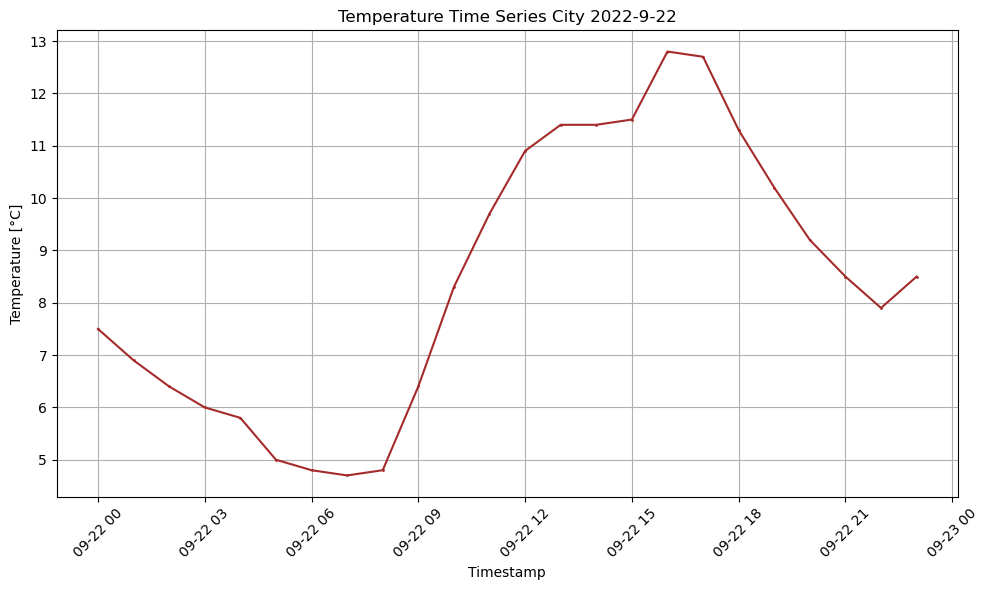

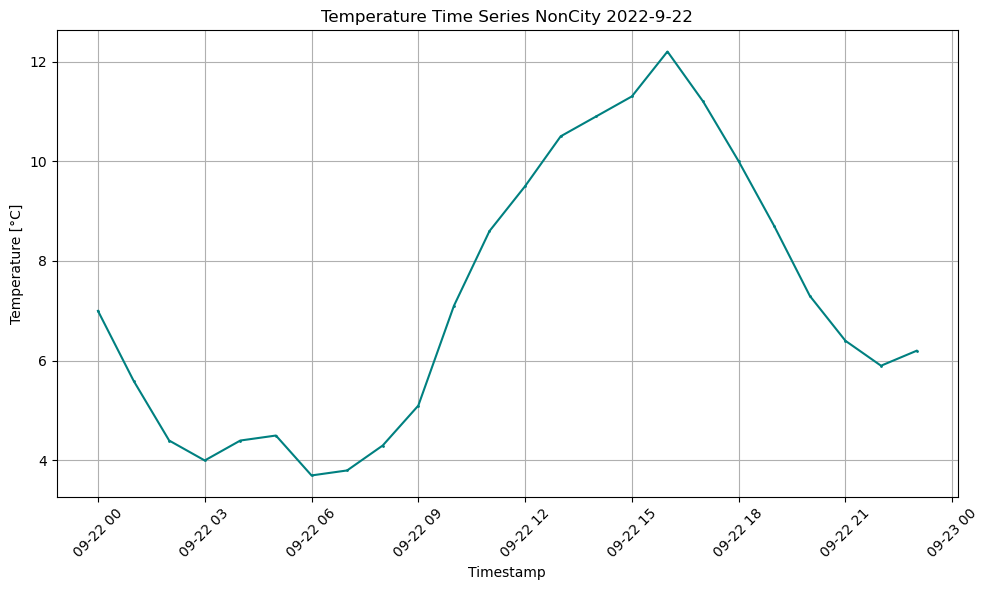

In [10]:
df = df_city_imp
# Filter data for a specific day
year = 2022
month = 9
day = 22
df_specific_day = df[(df.index.year == year) & (df.index.month == month) & (df.index.day == day)]

# Plot the temperature time series for the specific day
plt.figure(figsize=(10, 6))
plt.plot(df_specific_day['y'], marker='.', markersize=2, color='brown')
plt.title(f'Temperature Time Series City {year}-{month}-{day}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df = df_noncity_imp
# Filter data for a specific day
year = 2022
month = 9
day = 22
df_specific_day = df[(df.index.year == year) & (df.index.month == month) & (df.index.day == day)]

# Plot the temperature time series for the specific day
plt.figure(figsize=(10, 6))
plt.plot(df_specific_day['y'], marker='.', markersize=2, color='teal')
plt.title(f'Temperature Time Series NonCity {year}-{month}-{day}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Building a forecasting model
- feature engineering
- training
- forecasting

### Feature engineering
In order to make predictions by fitting a model, we need to first decide which features to use.

Remember the dataframe columns? These can be used as features.
![dataframe noncity](dataframe.png)

Some features we could use:
- temperature measurements
- observation station
- year
- month
- day
- time (hour)
- lagged variables

Since there are different temporal dynamics (seasonal variation, dialy vairation, maybe something else), using information about these dynamics from the time component variables (year, month, day, and day of the week and hour) can help the prediction. Since there are daily and seasonal patterns in the data, using the month and the hour is a good starting point, as other time components might not add much new information.

If we were interested in predicting the future, we might be interested in a trend analysis. This means that we try to understand if there is an average increase or decrease in the data values in time, once the seasonality (repeating patterns in time) is taken into account.

In [56]:
def create_feature_set(feature_set, year=False, month=True, day=False, dow=False, hour=True):
    ''' Add time component features '''
    
    if year: feature_set['year'] = feature_set.index.year
    if month: feature_set['month'] = feature_set.index.month
    if day: feature_set['day'] = feature_set.index.day
    if dow: feature_set['day_of_week'] = feature_set.index.dayofweek
    if hour: feature_set['hour'] = feature_set.index.hour
    display(feature_set)
    
    return feature_set

In [57]:
features_city = create_feature_set(df_city_imp)
features_noncity = create_feature_set(df_noncity_imp)

,y,month,hour
2021-04-10 00:00:00,3.4,4,0
2021-04-10 01:00:00,3.7,4,1
2021-04-10 02:00:00,3.9,4,2
2021-04-10 03:00:00,3.7,4,3
2021-04-10 04:00:00,3.5,4,4
...,...,...,...
2024-05-14 19:00:00,14.3,5,19
2024-05-14 20:00:00,13.4,5,20
2024-05-14 21:00:00,12.2,5,21
2024-05-14 22:00:00,10.7,5,22


,y,month,hour
2021-04-10 00:00:00,2.6,4,0
2021-04-10 01:00:00,2.7,4,1
2021-04-10 02:00:00,2.8,4,2
2021-04-10 03:00:00,2.7,4,3
2021-04-10 04:00:00,2.5,4,4
...,...,...,...
2024-05-14 19:00:00,17.0,5,19
2024-05-14 20:00:00,15.3,5,20
2024-05-14 21:00:00,13.0,5,21
2024-05-14 22:00:00,10.9,5,22


### Train test split

In order to evaluate the performance of the model, the data is split into a training set and a testing set. Generally the more data there is available for training the better. Common splits are between $70$%-$90$% training and $10$%-$30$% testing.

We can in this case go with approximately a $\frac{1}{3}$ split. We do not have a large dataset (only 3 years) so a $70$%-$30$% train-test split is rather on the small side for the training data. However in this application it can make semantic sense to train the model on two years and try to predict the third year, and this split gives us approximately that.

### The variables X and y
The prediction models work by feeding in the feature matrix (multiple columns) $X$ in order to return a prediction vector (column) $\hat{y}$, which in this case in the temperature. To do this, we first need to train the model with the feature matrix $X$ against our observed measurement vector $y$, finding the optimised model the minimises an error measure. This means that this is a _supervised learning_ problem.

In [23]:
def create_train_test_set(feature_set, v=False):
    # Split data into training and test sets
    train, test = train_test_split(feature_set, test_size=0.3, shuffle=False)

    # Prepare X and y
    # y vector (column) is the temperature measurements
    # X is the feature matrix
    X_train = train.drop('y', axis=1)
    v and print("X_train")
    v and display(X_train)
    
    y_train = train['y']
    v and print("y_train")
    v and display(y_train)
    
    X_test = test.drop('y', axis=1)
    v and print("X_test")
    v and display(X_test)
    
    y_test = test['y']
    v and print("y_test")
    v and display(y_test)

    return X_train, y_train, X_test, y_test

In [42]:
def fit_predict_evaluate_model(split, feature_set, method, v):
    '''fit a model with different methods, predict the temperature, and evaluate with test observations'''
    
    X_train, y_train, X_test, y_test = split(feature_set, v)
    
    if method == 'XGB':
        # fit the model with training data
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)
        
        # use the model to predict temperatures from the test features
        forecast = xgb_model.predict(X_test)
        print("forecast XGB")
        display(forecast)
        print(len(forecast))
        
        #evaluate the model
        mae = mean_absolute_error(y_test, forecast)
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        rmse = mean_squared_error(y_test, forecast, squared=False)
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        
        return forecast, y_test

    if method == 'CAT':
        pass
    
    if method == 'LIGHT':
        pass

In [44]:
v = True # set to true to see the train-test sets
forecast_xgb_city, observed_city = fit_predict_evaluate_model(create_train_test_set, features_city, method='XGB',v=v)
forecast_xgb_noncity, observed_noncity = fit_predict_evaluate_model(create_train_test_set, features_noncity, method='XGB',v=v)

X_train


,month,hour
2021-04-10 00:00:00,4,0
2021-04-10 01:00:00,4,1
2021-04-10 02:00:00,4,2
2021-04-10 03:00:00,4,3
2021-04-10 04:00:00,4,4
...,...,...
2023-06-10 11:00:00,6,11
2023-06-10 12:00:00,6,12
2023-06-10 13:00:00,6,13
2023-06-10 14:00:00,6,14


y_train


2021-04-10 00:00:00     3.4
2021-04-10 01:00:00     3.7
2021-04-10 02:00:00     3.9
2021-04-10 03:00:00     3.7
2021-04-10 04:00:00     3.5
                       ... 
2023-06-10 11:00:00    15.6
2023-06-10 12:00:00    16.5
2023-06-10 13:00:00    15.7
2023-06-10 14:00:00    15.5
2023-06-10 15:00:00    16.1
Name: y, Length: 19002, dtype: float64

X_test


,month,hour
2023-06-10 16:00:00,6,16
2023-06-10 17:00:00,6,17
2023-06-10 18:00:00,6,18
2023-06-10 19:00:00,6,19
2023-06-10 20:00:00,6,20
...,...,...
2024-05-14 19:00:00,5,19
2024-05-14 20:00:00,5,20
2024-05-14 21:00:00,5,21
2024-05-14 22:00:00,5,22


y_test


2023-06-10 16:00:00    15.8
2023-06-10 17:00:00    15.7
2023-06-10 18:00:00    15.4
2023-06-10 19:00:00    14.8
2023-06-10 20:00:00    14.3
                       ... 
2024-05-14 19:00:00    14.3
2024-05-14 20:00:00    13.4
2024-05-14 21:00:00    12.2
2024-05-14 22:00:00    10.7
2024-05-14 23:00:00    10.2
Name: y, Length: 8145, dtype: float64

forecast XGB


array([20.782087, 20.808172, 20.553146, ..., 11.417872, 10.394511,
        9.540921], dtype=float32)

8145
Mean Absolute Error (MAE): 3.91
Root Mean Squared Error (RMSE): 5.13
X_train


,month,hour
2021-04-10 00:00:00,4,0
2021-04-10 01:00:00,4,1
2021-04-10 02:00:00,4,2
2021-04-10 03:00:00,4,3
2021-04-10 04:00:00,4,4
...,...,...
2023-06-10 11:00:00,6,11
2023-06-10 12:00:00,6,12
2023-06-10 13:00:00,6,13
2023-06-10 14:00:00,6,14


y_train


2021-04-10 00:00:00     2.6
2021-04-10 01:00:00     2.7
2021-04-10 02:00:00     2.8
2021-04-10 03:00:00     2.7
2021-04-10 04:00:00     2.5
                       ... 
2023-06-10 11:00:00    15.3
2023-06-10 12:00:00    15.6
2023-06-10 13:00:00    17.2
2023-06-10 14:00:00    17.4
2023-06-10 15:00:00    17.9
Name: y, Length: 19002, dtype: float64

X_test


,month,hour
2023-06-10 16:00:00,6,16
2023-06-10 17:00:00,6,17
2023-06-10 18:00:00,6,18
2023-06-10 19:00:00,6,19
2023-06-10 20:00:00,6,20
...,...,...
2024-05-14 19:00:00,5,19
2024-05-14 20:00:00,5,20
2024-05-14 21:00:00,5,21
2024-05-14 22:00:00,5,22


y_test


2023-06-10 16:00:00    17.7
2023-06-10 17:00:00    16.4
2023-06-10 18:00:00    15.2
2023-06-10 19:00:00    14.1
2023-06-10 20:00:00    13.5
                       ... 
2024-05-14 19:00:00    17.0
2024-05-14 20:00:00    15.3
2024-05-14 21:00:00    13.0
2024-05-14 22:00:00    10.9
2024-05-14 23:00:00     9.5
Name: y, Length: 8145, dtype: float64

forecast XGB


array([21.542227 , 20.858797 , 20.384897 , ..., 10.887567 ,  9.496933 ,
        8.2173605], dtype=float32)

8145
Mean Absolute Error (MAE): 4.00
Root Mean Squared Error (RMSE): 5.20


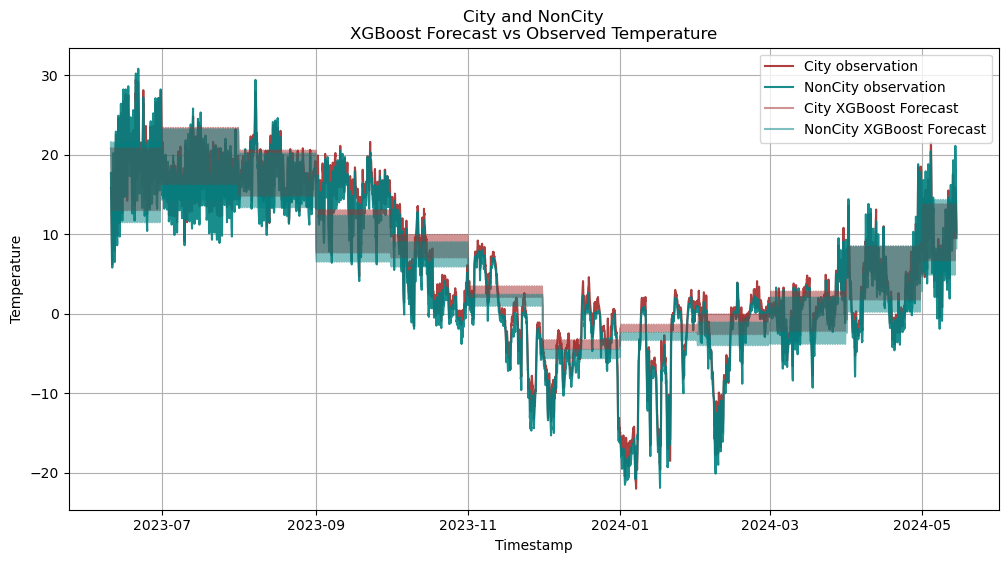

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(observed_city.index, observed_city, label='City observation', color='brown', alpha=0.9)
plt.plot(observed_noncity.index, observed_noncity, label='NonCity observation', color='teal', alpha=0.9)
plt.plot(observed_city.index, forecast_xgb_city, label='City XGBoost Forecast', alpha=0.5, color='brown')
plt.plot(observed_noncity.index, forecast_xgb_noncity, label='NonCity XGBoost Forecast', alpha=0.5, color='teal')
plt.title('City and NonCity\nXGBoost Forecast vs Observed Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

### Trying with more features

In [58]:
features_full_city = create_feature_set(df_city_imp, year=True, month=True, day=True, dow=True, hour=True)
features_full_noncity = create_feature_set(df_noncity_imp, year=True, month=True, day=True, dow=True, hour=True)

,y,month,hour,year,day,day_of_week
2021-04-10 00:00:00,3.4,4,0,2021,10,5
2021-04-10 01:00:00,3.7,4,1,2021,10,5
2021-04-10 02:00:00,3.9,4,2,2021,10,5
2021-04-10 03:00:00,3.7,4,3,2021,10,5
2021-04-10 04:00:00,3.5,4,4,2021,10,5
...,...,...,...,...,...,...
2024-05-14 19:00:00,14.3,5,19,2024,14,1
2024-05-14 20:00:00,13.4,5,20,2024,14,1
2024-05-14 21:00:00,12.2,5,21,2024,14,1
2024-05-14 22:00:00,10.7,5,22,2024,14,1


,y,month,hour,year,day,day_of_week
2021-04-10 00:00:00,2.6,4,0,2021,10,5
2021-04-10 01:00:00,2.7,4,1,2021,10,5
2021-04-10 02:00:00,2.8,4,2,2021,10,5
2021-04-10 03:00:00,2.7,4,3,2021,10,5
2021-04-10 04:00:00,2.5,4,4,2021,10,5
...,...,...,...,...,...,...
2024-05-14 19:00:00,17.0,5,19,2024,14,1
2024-05-14 20:00:00,15.3,5,20,2024,14,1
2024-05-14 21:00:00,13.0,5,21,2024,14,1
2024-05-14 22:00:00,10.9,5,22,2024,14,1


In [59]:
v = False # set to true to see the train-test sets
forecast_full_xgb_city, observed_city = fit_predict_evaluate_model(create_train_test_set, features_full_city, method='XGB',v=v)
forecast_full_xgb_noncity, observed_noncity = fit_predict_evaluate_model(create_train_test_set, features_full_noncity, method='XGB',v=v)

forecast XGB


array([18.461874, 18.48422 , 18.590801, ..., 15.257989, 14.207429,
       13.355193], dtype=float32)

8145
Mean Absolute Error (MAE): 4.54
Root Mean Squared Error (RMSE): 5.87
forecast XGB


array([19.095446, 19.121525, 18.569473, ..., 15.255495, 13.884927,
       12.34818 ], dtype=float32)

8145
Mean Absolute Error (MAE): 4.68
Root Mean Squared Error (RMSE): 6.05


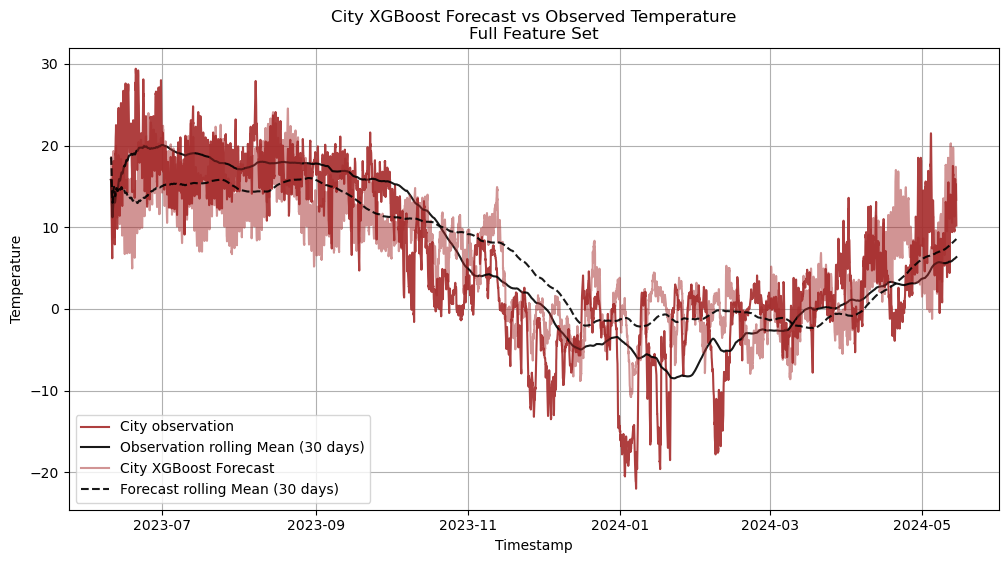

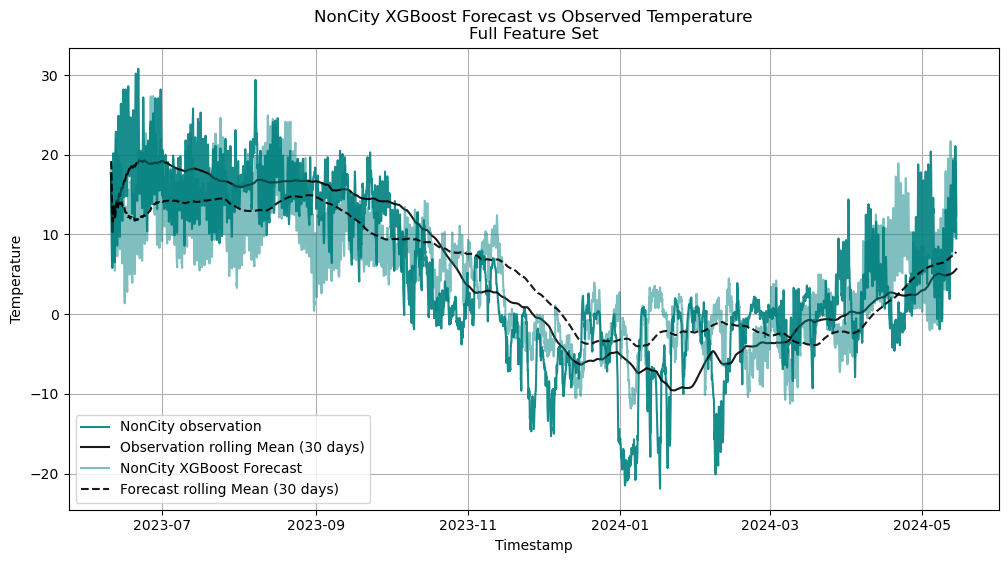

In [83]:
# City
rolling_mean_observation_city = df = pd.DataFrame(observed_city.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()
rolling_mean_forecast_full_city = pd.DataFrame(forecast_full_xgb_city.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(observed_city.index, observed_city, label='City observation', color='brown', alpha=0.9)
plt.plot(observed_city.index, rolling_mean_observation_city, label='Observation rolling Mean (30 days)', alpha=0.9, color='black')
plt.plot(observed_city.index, forecast_full_xgb_city, label='City XGBoost Forecast', alpha=0.5, color='brown')
plt.plot(observed_city.index, rolling_mean_forecast_full_city, '--', label='Forecast rolling Mean (30 days)', alpha=0.9, color='black')
plt.title('City XGBoost Forecast vs Observed Temperature\nFull Feature Set')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# NonCity
rolling_mean_observation_noncity = pd.DataFrame(observed_noncity.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()
rolling_mean_forecast_full_noncity = pd.DataFrame(forecast_full_xgb_noncity.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(observed_noncity.index, observed_noncity, label='NonCity observation', color='teal', alpha=0.9)
plt.plot(observed_city.index, rolling_mean_observation_noncity, label='Observation rolling Mean (30 days)', alpha=0.9, color='black')
plt.plot(observed_noncity.index, forecast_full_xgb_noncity, label='NonCity XGBoost Forecast', alpha=0.5, color='teal')
plt.plot(observed_city.index, rolling_mean_forecast_full_noncity, '--', label='Forecast rolling Mean (30 days)', alpha=0.9, color='black')
plt.title('NonCity XGBoost Forecast vs Observed Temperature\nFull Feature Set')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

## Visual comparison of predictions
- xgboost
- lightgbm
- catboost
- rolling mean

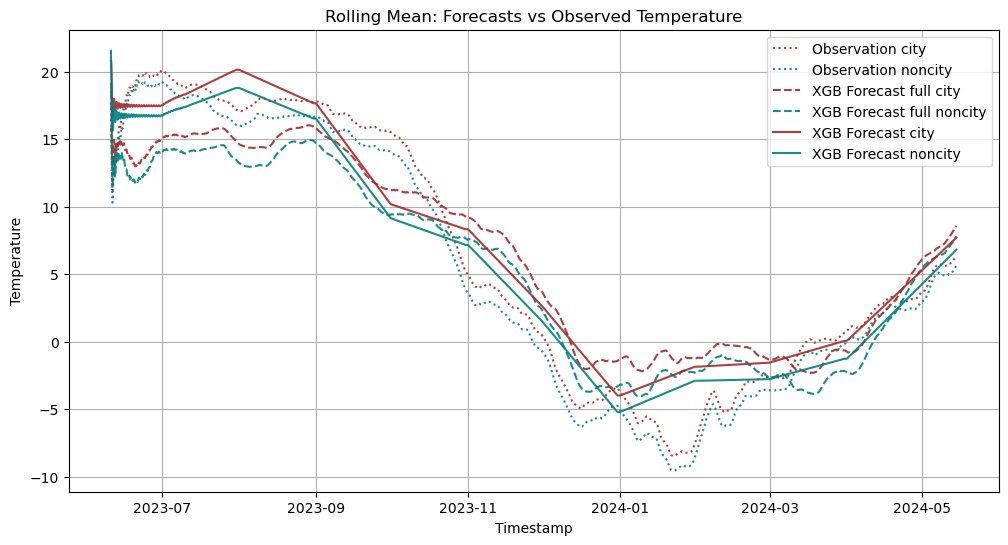

In [92]:
# Rolling means

# means from month + hour prediction
rolling_mean_forecast_city = pd.DataFrame(forecast_xgb_city.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()
rolling_mean_forecast_noncity = pd.DataFrame(forecast_xgb_noncity.T, columns=['y']).rolling(window=24*30, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(observed_city.index, rolling_mean_observation_city, linestyle='dotted', label='Observation city', alpha=0.9, color='brown')
plt.plot(observed_city.index, rolling_mean_observation_noncity, linestyle='dotted', label='Observation noncity', alpha=0.9, color='teal')
plt.plot(observed_city.index, rolling_mean_forecast_full_city, '--', label='XGB Forecast full city', alpha=0.9, color='brown')
plt.plot(observed_city.index, rolling_mean_forecast_full_noncity, '--', label='XGB Forecast full noncity', alpha=0.9, color='teal')
plt.plot(observed_city.index, rolling_mean_forecast_city, linestyle='solid', label='XGB Forecast city', alpha=0.9, color='brown')
plt.plot(observed_city.index, rolling_mean_forecast_noncity, linestyle='solid', label='XGB Forecast noncity', alpha=0.9, color='teal')
plt.title('Rolling Mean: Forecasts vs Observed Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()